Dependecies

In [1]:
library(mice)
library(norm)
library(ggplot2)
library(psych)
library(lavaan)
library(lmtest)


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


This package has some major limitations
(for example, it does not work reliably when
the number of variables exceeds 30),
and has been superseded by the norm2 package.


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


This is lavaan 0.6-11
lavaan is FREE software! Please report any bugs.


Attaching package: ‘lavaan’


The following object is masked from ‘package:psych’:

    cor2cov


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:
FIG_DIR = 'figs'

# Dataset
Load and examine the dataset

In [3]:
# Note: data have been manually cleaned somewhat;
# tabs have been coverted to spaces for consistency
raw_data = read.table('pain.dat', sep=' ', header=TRUE, na.strings='.')
raw_data$female = raw_data$female == 1
raw_data$severity = factor(raw_data$severity, levels=1:6, ordered=TRUE)
summary(raw_data)

   female           depress         phydisab       psydisab     severity 
 Mode :logical   Min.   :1.100   Min.   : 5.0   Min.   : 4.80   1   :29  
 FALSE:130       1st Qu.:3.100   1st Qu.: 8.3   1st Qu.: 9.70   2   :30  
 TRUE :180       Median :3.900   Median : 9.9   Median :10.90   3   :43  
                 Mean   :3.792   Mean   :10.0   Mean   :10.95   4   :72  
                 3rd Qu.:4.400   3rd Qu.:11.7   3rd Qu.:12.30   5   :90  
                 Max.   :6.900   Max.   :16.2   Max.   :17.00   6   :30  
                 NA's   :67      NA's   :9      NA's   :4       NA's:16  
      age    
 Min.   : 7  
 1st Qu.:36  
 Median :46  
 Mean   :44  
 3rd Qu.:52  
 Max.   :74  
             

In [4]:
raw_data

female,depress,phydisab,psydisab,severity,age
<lgl>,<dbl>,<dbl>,<dbl>,<ord>,<int>
FALSE,4.5,12.6,9.8,2,44
FALSE,3.2,10.2,10.9,4,52
FALSE,1.8,8.2,10.9,3,35
FALSE,5.7,9.9,9.0,5,7
FALSE,3.9,6.4,9.6,2,34
FALSE,2.2,12.4,12.0,2,43
FALSE,4.4,11.6,9.2,4,26
FALSE,4.9,11.0,11.2,6,51
FALSE,5.2,7.8,10.3,4,33


Get an overview of the missingness pattern

In [5]:
missing_rates = colSums(is.na(raw_data)) / nrow(raw_data)
print(missing_rates)

    female    depress   phydisab   psydisab   severity        age 
0.00000000 0.21612903 0.02903226 0.01290323 0.05161290 0.00000000 


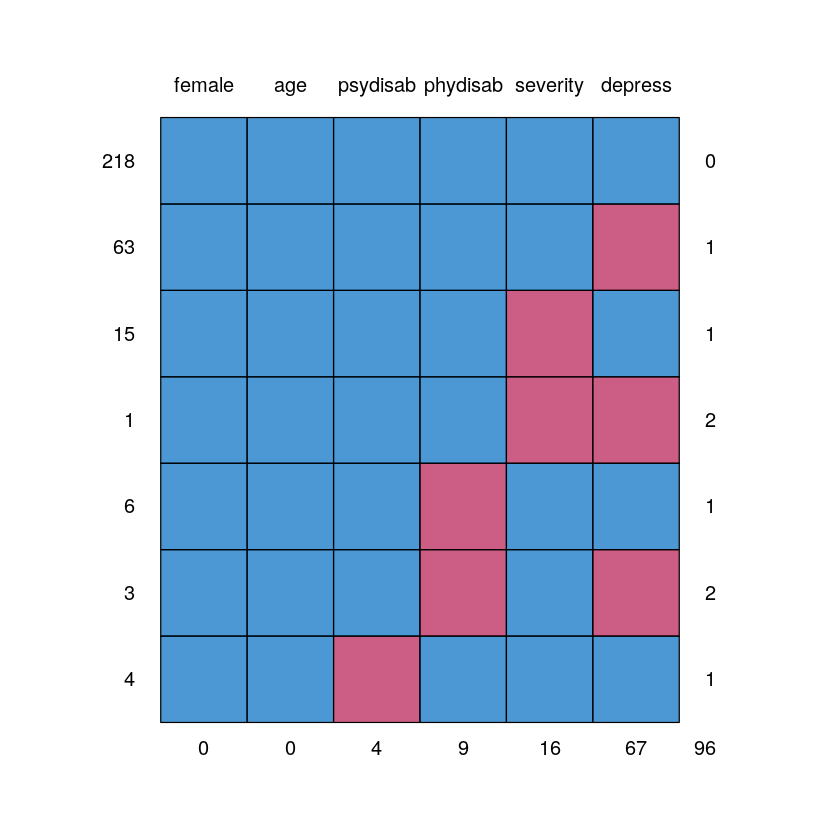

In [6]:
tmp = md.pattern(raw_data)

In order to see which variables we should consider as covariates, we plot the correlations of all of the variables

Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphic

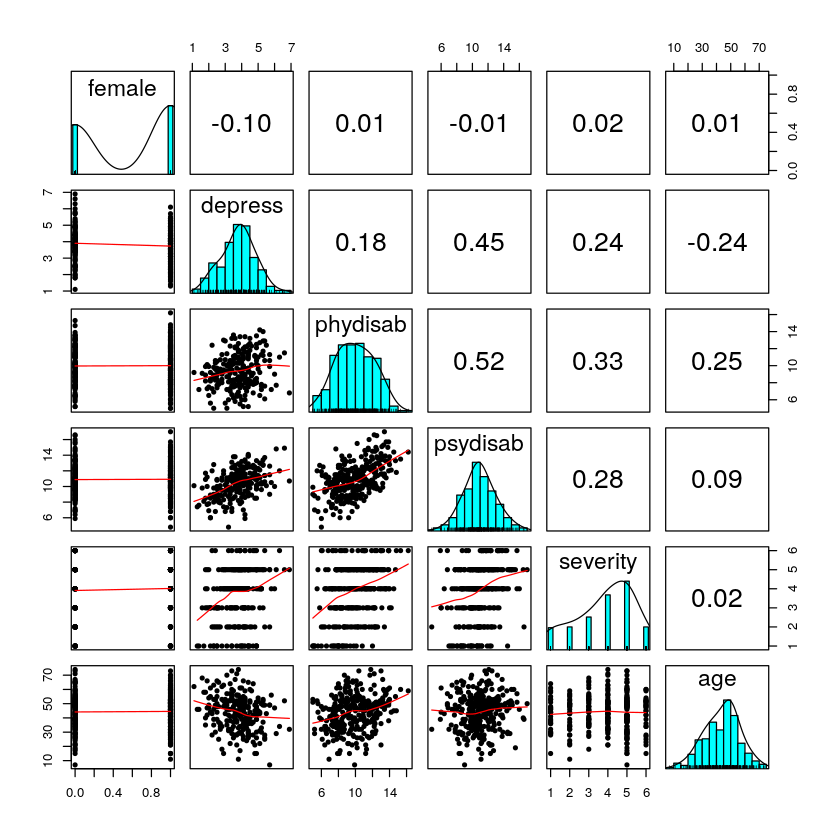

In [7]:
pairs.panels(raw_data,ellipses=FALSE)

# Helper Functions
## General
These can be used on any of the datasets

In [8]:
# Initialize psuedo-random number generator in a reasonably
# unpredictable way
set.seed(as.numeric(Sys.time()))

In [9]:
# Calculate the root mean squared error
get_rmse = function(actual, predictions) {
    residuals = actual - predictions
    return(sqrt(mean(residuals ^ 2)))
}

# Split the data into training and testing
get_training_indices = function(data, sample_rate=0.5) {
    num_subjects = nrow(data)
    return(sample(num_subjects, size=floor(sample_rate*num_subjects)))
}


evaluate_model = function(data, build_model, report_on_model, num_iters=10) {
    rmse = data.frame()
    for (i in 1:num_iters) {
        # We should train the model on different data than we use to test it
        training_indices = get_training_indices(data)
        training_data = data[training_indices]
        testing_data = data[-training_indices]

        model = build_model(training_data)
        #report_on_model(model, training_data, testing_data)
        
        training_rmse = get_rmse(training_data$depress -
                                 predict(model, training_data))
        testing_rmse = get_rmse(testing_data$depress -
                                predict(model, testing_data))
        rmse = rbind(rmse,
            data.frame(training=training_rmse, testing=testing_rmse))
    }
    
    return(rmse)
}

In [10]:
build_linear_model = function(data) {
    with(data, lm(
        depress ~ phydisab + psydisab + severity + age
    ))
}

build_reduced_linear_model = function(data) {
    with(data, lm(
        depress ~ severity + age
    ))
}

report_on_linear_model = function(model, training_data, testing_data) {

}

In [11]:
plot_residuals = function(model, multiple_datasets=FALSE,
                         append=FALSE, colour='black') {
    
    if (multiple_datasets) {
        residual_val = NULL
        predicted_val = NULL
        for (i in 1:num_imputed_datasets) {
            residual_val = rbind(residual_val,residuals(model$analyses[[i]]))
            model_residuals = colMeans(residual_val)

            predicted_val = rbind(predicted_val,predict(model$analyses[[i]]))
            model_predictions = colMeans(predicted_val)
        }
        
    } else {
        model_residuals = model$residuals
        model_predictions = model$predictions
    }
    
    print(sprintf('Mean residual: %f', mean(model_residuals)))
    print(sprintf('Mean prediction: %f', mean(model_predictions)))
    
    if (append) {
        points(model_residuals,model_predictions,xlab='residuals',ylab='predictions',col=colour)
    } else {
        plot(model_residuals,model_predictions,xlab='residuals',ylab='predictions',col=colour)
    }
}

## Listwise Deletion

In [12]:
count_na = function(x) sum(is.na(x))
listwise_deletion = function(data) {
    completeness_mask = apply(data, 1, count_na) == 0
    return(subset(data, completeness_mask))
}

## Multiple Imputation

In [13]:
num_imputed_datasets = 20
num_entries = nrow(raw_data)
CONTINUOUS_COLS = c('depress','phydisab','psydisab','age')

summarize_pooled_results = function(mi_results,
        summary_cols=CONTINUOUS_COLS, mr=missing_rates,
        m=num_imputed_datasets, n=num_entries,
        precision=3) {
    imputed_datasets = complete(mi_results, 'all')

    # Compute the means for each dataset...
    imputed_means = sapply(imputed_datasets, function(dataset) {
        apply(dataset[summary_cols],2,mean)
    })
    
    # ...then combine them...
    grand_means = apply(imputed_means,1,mean)
    
    # ...and compute summary statistics
    
    std_err = sapply(imputed_datasets, function(dataset) {
        apply(dataset[summary_cols],2,sd) / sqrt(n)
    })
    
    within_impute_var = apply(std_err^2,1,mean)
    
    btw_impute_var = rep(NA,length(summary_cols))
    names(btw_impute_var) = names(within_impute_var)

    for (j in 1:nrow(imputed_means)) {
        btw_impute_var[j] = sum((imputed_means[j,] -
            grand_means[j])^2 / (m - 1))
    }

    total_var = within_impute_var + btw_impute_var +
        btw_impute_var / m
    total_std_err = sqrt(total_var)
    
    fmi = (btw_impute_var + btw_impute_var/m) / total_std_err
    
    pooled_stats = round(data.frame(
        mean=grand_means,Vw=within_impute_var,Vb=btw_impute_var,
        SE=total_std_err,Vt=total_var,FMI=fmi,MR=mr[summary_cols]),precision)
    
    return(pooled_stats)
}

## Maximum Likelihood Estimation

In [14]:
# Estimate mean, standard deviation, covariance matrix, and correlation
em = function(data, cols=NULL) {
    if (is.null(cols)) {
        cols = names(data)
    }
    
    summary = prelim.norm(data.matrix(data[cols]))
    results_vec = em.norm(summary, showits=FALSE)
    return(getparam.norm(summary, results_vec, corr=TRUE))
}

get_covariance = function(em_results) {
    std_dev = diag(em_results$sdv)
    return(std_dev %*% em_results$r %*% std_dev)
}

get_std_error = function(covariance, indep_col, num_cases) {
    y_variance = covariance[indep_col,]
    #x_covariance = covariance[-indep_col,-indep_col]
    
    sqr_err = diag(y_variance*solve(covariance))
    std_err = sqrt(abs(sqr_err)/num_cases)
    return (std_err)
}

# Estimate regression coeffecients, based on example in Likelihood.R
coeff_em = function(data, em_results, indep_col, predictor_cols=NULL,
        offset=0) {
    if (is.null(predictor_cols)) {
        predictor_cols = data[-indep_col]
    }
    
    covariance = get_covariance(em_results)
    
    covariance_dep = covariance[predictor_cols, predictor_cols]
    covariance_mixed = covariance[predictor_cols, indep_col]
    coeffs = solve(covariance_dep) %*% covariance_mixed
    
    intercept = em_results$mu[indep_col] -
        sum(coeffs * em_results$mu[predictor_cols])
    coeffs = rbind(c(intercept), coeffs)
    
    rownames(coeffs) = append(c('(Intercept)'),
        colnames(data)[offset+predictor_cols])
    coeffs = data.frame(coeffs)
    
    std_err = get_std_error(covariance, indep_col, nrow(data))
    coeffs$std_err = std_err[c(indep_col,predictor_cols)]
    coeffs$corr = em_results$r[indep_col,c(indep_col,predictor_cols)]
    
    return(coeffs)
}

# Analysis

## Full Data

In [15]:
pdf(file.path(FIG_DIR,'correlations_full_data.pdf'))
pairs.panels(raw_data,ellipses=FALSE)
dev.off()

Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphic

png 
  2

In [16]:
full_data_model_fits = list(stratum='full data')
full_data_lr_tests = list(stratum='full data')

### Listwise Deletion

In [17]:
complete_case_data = listwise_deletion(raw_data)
summary(complete_case_data)

   female           depress         phydisab        psydisab     severity
 Mode :logical   Min.   :1.400   Min.   : 5.00   Min.   : 4.80   1:23    
 FALSE:96        1st Qu.:3.200   1st Qu.: 7.90   1st Qu.: 9.20   2:25    
 TRUE :122       Median :3.900   Median : 9.30   Median :10.60   3:38    
                 Mean   :3.811   Mean   : 9.35   Mean   :10.37   4:54    
                 3rd Qu.:4.400   3rd Qu.:10.80   3rd Qu.:11.40   5:63    
                 Max.   :6.900   Max.   :14.20   Max.   :14.90   6:15    
      age      
 Min.   : 7.0  
 1st Qu.:34.0  
 Median :43.5  
 Mean   :43.0  
 3rd Qu.:52.0  
 Max.   :74.0  

In [18]:
complete_case_model = build_linear_model(complete_case_data)
full_data_model_fits[['complete case']] = summary(complete_case_model)
full_data_model_fits[['complete case']]


Call:
lm(formula = depress ~ phydisab + psydisab + severity + age)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.38034 -0.55649  0.05219  0.56299  2.66337 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.998730   0.431173   4.636 6.26e-06 ***
phydisab     0.035347   0.034040   1.038   0.3003    
psydisab     0.227745   0.035763   6.368 1.20e-09 ***
severity.L   0.337230   0.191124   1.764   0.0791 .  
severity.Q   0.314770   0.182818   1.722   0.0866 .  
severity.C  -0.185843   0.160762  -1.156   0.2490    
severity^4  -0.127011   0.148037  -0.858   0.3919    
severity^5   0.122424   0.133539   0.917   0.3603    
age         -0.020510   0.004912  -4.175 4.37e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8642 on 209 degrees of freedom
Multiple R-squared:  0.2962,	Adjusted R-squared:  0.2693 
F-statistic:    11 on 8 and 209 DF,  p-value: 6.399e-13


In [19]:
reduced_complete_case_model = build_reduced_linear_model(complete_case_data)
summary(reduced_complete_case_model)


Call:
lm(formula = depress ~ severity + age)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.16503 -0.64207  0.05253  0.65818  2.62694 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.530923   0.237462  19.081  < 2e-16 ***
severity.L   0.531194   0.207781   2.557  0.01128 *  
severity.Q   0.200847   0.196326   1.023  0.30747    
severity.C  -0.188549   0.177722  -1.061  0.28994    
severity^4  -0.236499   0.161740  -1.462  0.14517    
severity^5   0.164926   0.147621   1.117  0.26517    
age         -0.017441   0.005281  -3.302  0.00113 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9567 on 211 degrees of freedom
Multiple R-squared:  0.1291,	Adjusted R-squared:  0.1044 
F-statistic: 5.215 on 6 and 211 DF,  p-value: 4.999e-05


In [20]:
full_data_lr_tests[['complete case']] =
    lrtest(complete_case_model, reduced_complete_case_model)
full_data_lr_tests[['complete case']]

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10,-272.9102,NA,NA,NA
2,8,-296.1265,-2,46.43263,8.265762e-11


In [21]:
# Can only compute for numeric columns
cor(complete_case_data[c(2,3,4,6)],method='pearson')

,depress,phydisab,psydisab,age
depress,1.0000000,0.1477519,0.42938212,-0.23494867
phydisab,0.1477519,1.0000000,0.32588131,0.22258250
psydisab,0.4293821,0.3258813,1.00000000,0.04672804
age,-0.2349487,0.2225825,0.04672804,1.00000000


[1] "Mean residual: -0.000000"
[1] "Mean prediction: 3.811009"


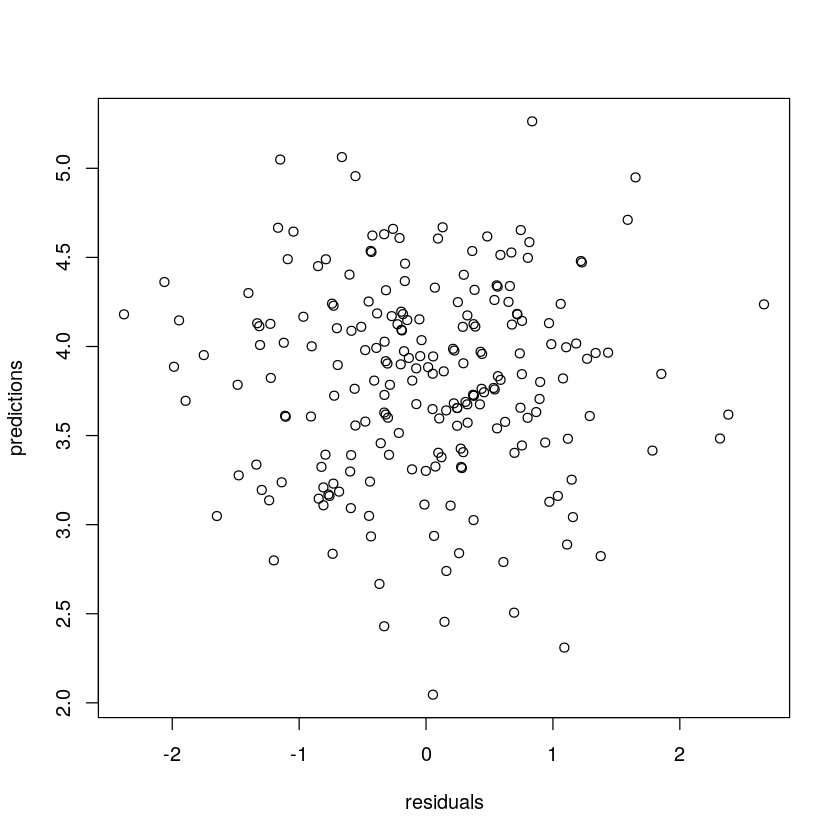

In [22]:
complete_case_model$predictions = predict(complete_case_model,
    newdata=complete_case_data)
plot_residuals(complete_case_model)

#### Multiple Imputation

In [23]:
mi_data = mice(raw_data, m=num_imputed_datasets, maxit=20, seed=664,
    defaultMethod=c('norm.nob','logreg','lda','polr'))


 iter imp variable
  1   1  depress  phydisab  psydisab  severity
  1   2  depress  phydisab  psydisab  severity
  1   3  depress  phydisab  psydisab  severity
  1   4  depress  phydisab  psydisab  severity
  1   5  depress  phydisab  psydisab  severity
  1   6  depress  phydisab  psydisab  severity
  1   7  depress  phydisab  psydisab  severity
  1   8  depress  phydisab  psydisab  severity
  1   9  depress  phydisab  psydisab  severity
  1   10  depress  phydisab  psydisab  severity
  1   11  depress  phydisab  psydisab  severity
  1   12  depress  phydisab  psydisab  severity
  1   13  depress  phydisab  psydisab  severity
  1   14  depress  phydisab  psydisab  severity
  1   15  depress  phydisab  psydisab  severity
  1   16  depress  phydisab  psydisab  severity
  1   17  depress  phydisab  psydisab  severity
  1   18  depress  phydisab  psydisab  severity
  1   19  depress  phydisab  psydisab  severity
  1   20  depress  phydisab  psydisab  severity
  2   1  depress  phydisab  p

In [24]:
summarize_pooled_results(mi_data, precision=5)

,mean,Vw,Vb,SE,Vt,FMI,MR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
depress,3.96434,0.00386,0.00031,0.06473,0.00419,0.00508,0.21613
phydisab,9.98785,0.01606,0.00014,0.12729,0.01620,0.00114,0.02903
psydisab,10.93652,0.01383,0.00006,0.11790,0.01390,0.00056,0.01290
age,44.00000,0.48798,0.00000,0.69856,0.48798,0.00000,0.00000


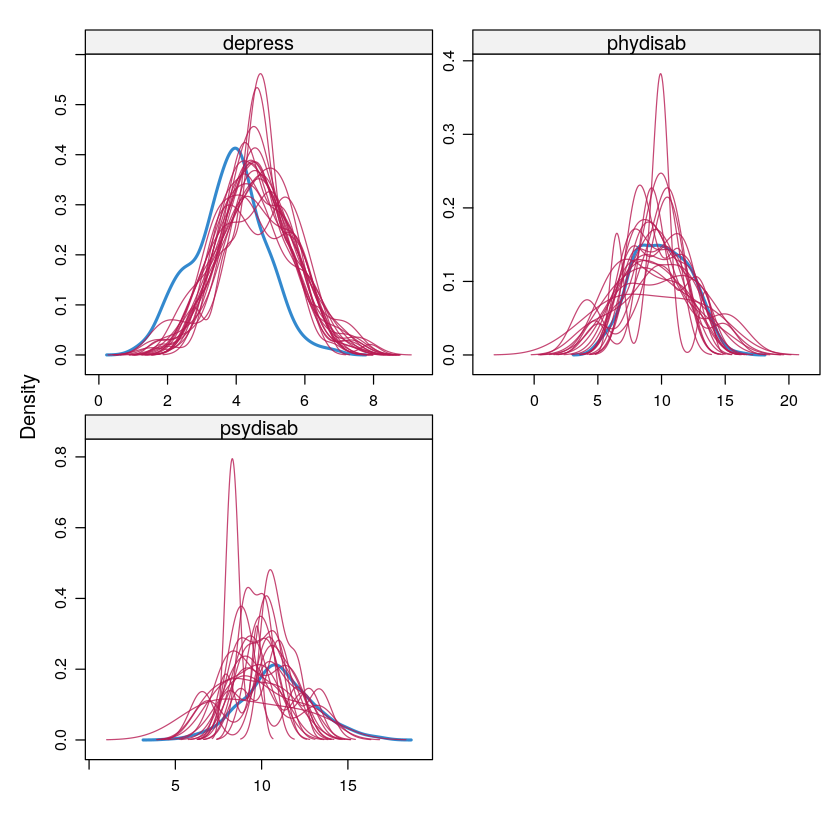

In [25]:
densityplot(mi_data)

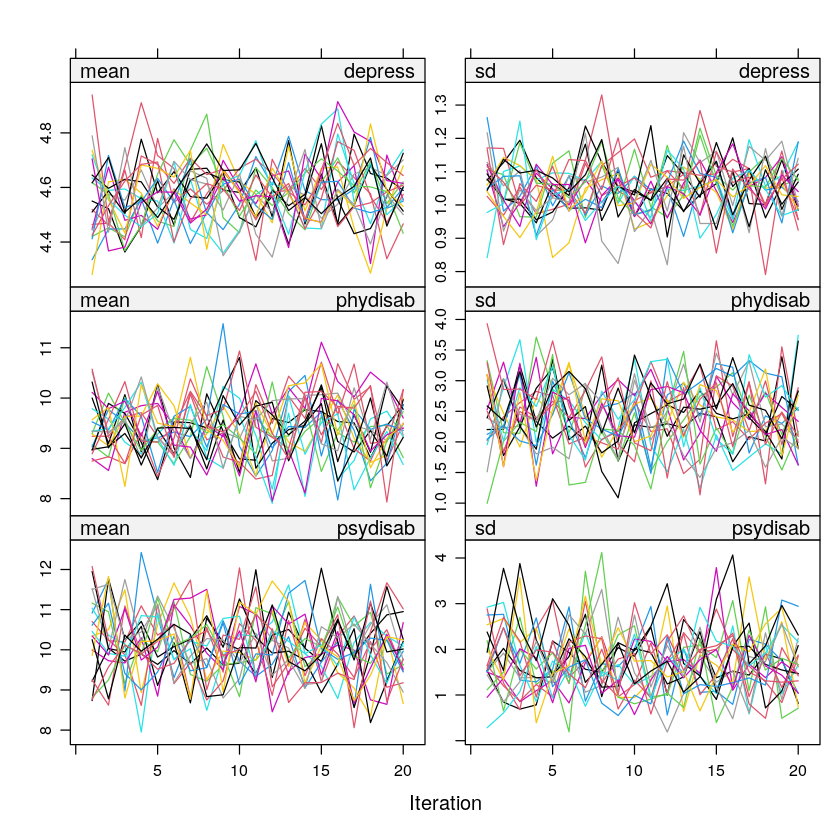

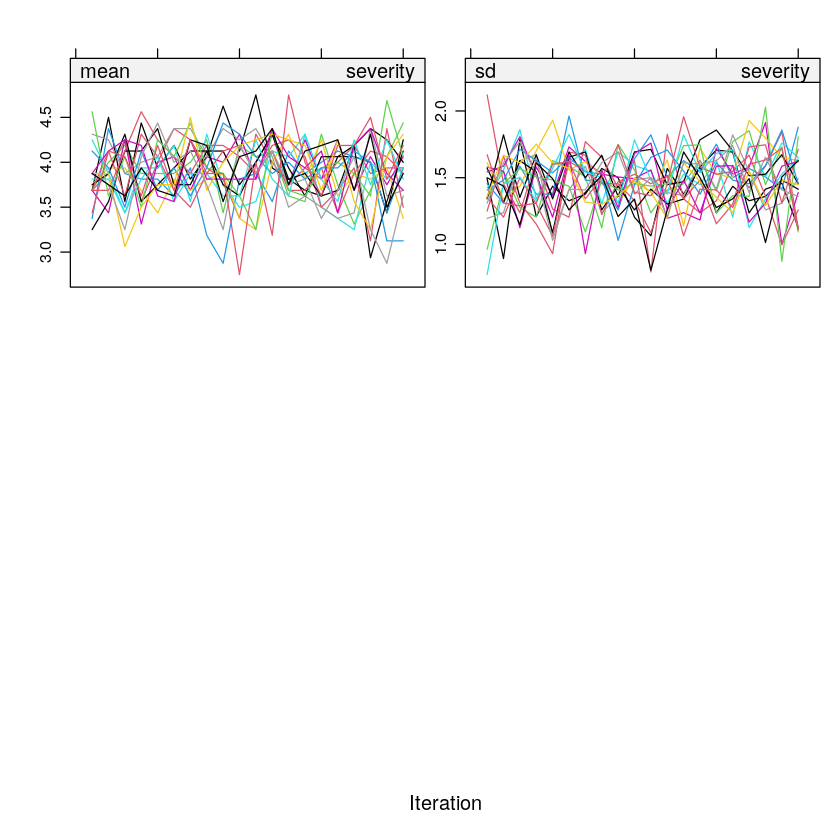

In [26]:
plot(mi_data)

In [27]:
mi_model = build_linear_model(mi_data)
full_data_model_fits[['multiple imputation']] = summary(pool(mi_model))
full_data_model_fits[['multiple imputation']]

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.91354816,0.360887460,5.3023404,164.78288,3.631562e-07
phydisab,0.04317350,0.030636649,1.4092110,185.65861,1.604455e-01
psydisab,0.23978853,0.031306129,7.6594757,178.97474,1.129541e-12
severity.L,0.40996024,0.168661208,2.4306730,216.23419,1.588585e-02
severity.Q,0.21697708,0.158964369,1.3649416,158.55938,1.742051e-01
severity.C,-0.14959548,0.164854561,-0.9074391,90.79018,3.665769e-01
severity^4,-0.10052562,0.140883760,-0.7135359,167.56606,4.765068e-01
severity^5,0.13504678,0.130917635,1.0315400,174.83031,3.037125e-01
age,-0.02365687,0.004575448,-5.1703950,189.37148,5.909514e-07


In [28]:
reduced_mi_model = build_reduced_linear_model(mi_data)
summary(pool(reduced_mi_model))

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.67097143,0.22956340,20.3471961,222.2563,0.000000e+00
severity.L,0.86883634,0.19041076,4.5629583,171.9186,9.563648e-06
severity.Q,0.21878021,0.18054827,1.2117546,183.0948,2.271678e-01
severity.C,-0.10596377,0.18665475,-0.5676993,102.5203,5.714803e-01
severity^4,-0.25594766,0.16080828,-1.5916323,183.2580,1.131908e-01
severity^5,0.25333160,0.14958898,1.6935178,194.5088,9.195773e-02
age,-0.01785687,0.00506065,-3.5285721,208.8609,5.137600e-04


In [29]:
full_data_lr_tests[['multiple imputation']] =
    summary(D3(mi_model,reduced_mi_model))
full_data_lr_tests[['multiple imputation']]

Models:
 model                                        formula
     1 depress ~ phydisab + psydisab + severity + age
     2                       depress ~ severity + age

Comparisons:
   test statistic df1      df2 dfcom      p.value       riv
 1 ~~ 2  35.84074   2 483.8504   301 3.108624e-15 0.3436528

Number of imputations:  20   Method D3

In [30]:
pool.r.squared(mi_model,adjusted=TRUE)

,est,lo 95,hi 95,fmi
adj R^2,0.3696368,0.2724912,0.4647413,0.2233393


In [31]:
tidy(pool(mi_model),conf.int=TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,b,df,dfcom,fmi,lambda,m,riv,ubar
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
(Intercept),1.91354816,0.360887460,5.3023404,3.631562e-07,1.20098855,2.62610776,2.376354e-02,164.78288,301,0.2012194,0.1915829,20,0.2369852,1.052880e-01
phydisab,0.04317350,0.030636649,1.4092110,1.604455e-01,-0.01726721,0.10361422,1.453942e-04,185.65861,301,0.1715268,0.1626499,20,0.1942436,7.859404e-04
psydisab,0.23978853,0.031306129,7.6594757,1.129541e-12,0.17801192,0.30156514,1.601944e-04,178.97474,301,0.1807283,0.1716240,20,0.2071812,8.118696e-04
severity.L,0.40996024,0.168661208,2.4306730,1.588585e-02,0.07752976,0.74239071,3.355832e-03,216.23419,301,0.1318607,0.1238680,20,0.1413805,2.492298e-02
severity.Q,0.21697708,0.158964369,1.3649416,1.742051e-01,-0.09698364,0.53093780,4.832648e-03,158.55938,301,0.2106987,0.2008052,20,0.2512593,2.019539e-02
severity.C,-0.14959548,0.164854561,-0.9074391,3.665769e-01,-0.47706901,0.17787805,8.718299e-03,90.79018,301,0.3509779,0.3368365,20,0.5079238,1.802281e-02
severity^4,-0.10052562,0.140883760,-0.7135359,4.765068e-01,-0.37866148,0.17761024,3.545435e-03,167.56606,301,0.1970850,0.1875586,20,0.2308580,1.612553e-02
severity^5,0.13504678,0.130917635,1.0315400,3.037125e-01,-0.12333564,0.39342920,2.894364e-03,174.83031,301,0.1865677,0.1773153,20,0.2155325,1.410034e-02
age,-0.02365687,0.004575448,-5.1703950,5.909514e-07,-0.03268226,-0.01463148,3.145435e-06,189.37148,301,0.1665185,0.1577621,20,0.1873130,1.763202e-05


[1] "Mean residual: -0.000000"
[1] "Mean prediction: 3.964339"


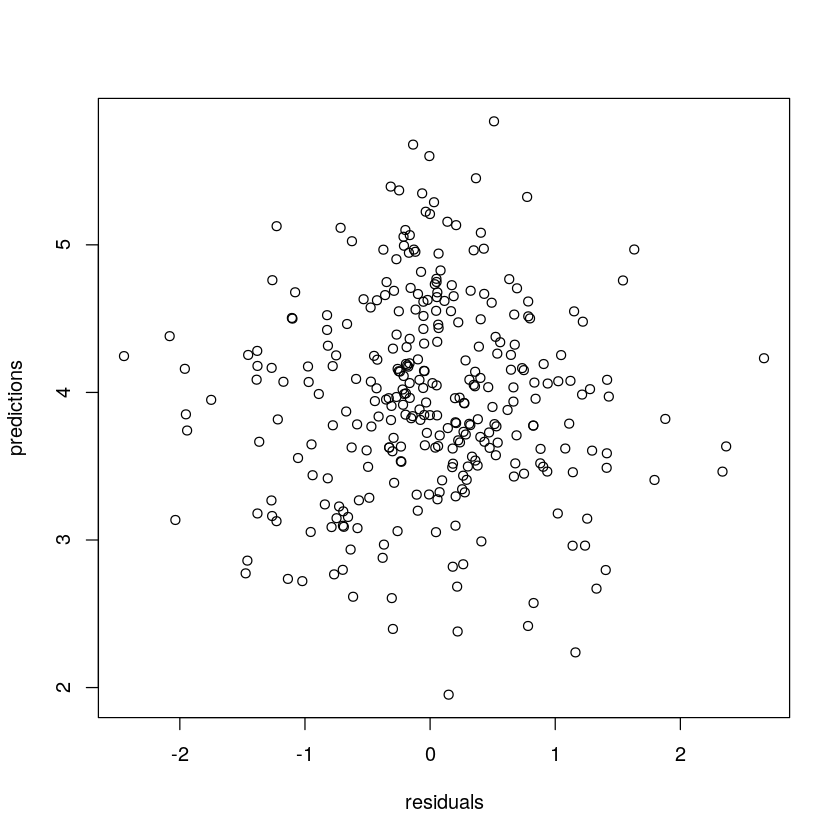

In [32]:
plot_residuals(mi_model, multiple_datasets=TRUE)

#### Maximum Likelihood Estimation

In [33]:
em_results = em(raw_data,
    cols=c('depress','phydisab','psydisab','severity','age'))
em_results

1.0000000,0.2966397,0.52056568,0.28861119,-0.20876228
0.2966397,1.0000000,0.52349136,0.33588927,0.25075107
0.5205657,0.5234914,1.00000000,0.27408933,0.08642906
0.2886112,0.3358893,0.27408933,1.00000000,0.01277475
-0.2087623,0.2507511,0.08642906,0.01277475,1.00000000


In [34]:
em_model_coeffs = coeff_em(raw_data, em_results, 1,
    predictor_cols=c(2,3,5),offset=1)
em_model_coeffs

,coeffs,std_err,corr
,<dbl>,<dbl>,<dbl>
(Intercept),1.70492218,0.07107254,1.0000000
phydisab,0.05481564,0.02704878,0.2966397
psydisab,0.25523778,0.03921796,0.5205657
age,-0.02467941,0.00841863,-0.2087623


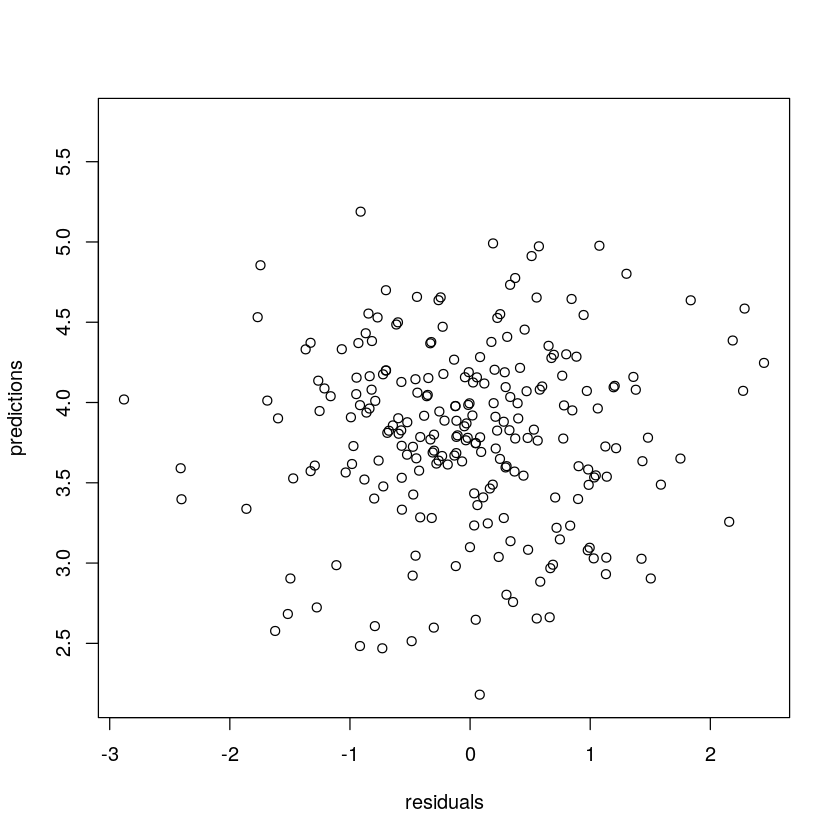

In [35]:
em_model_predictions = em_model_coeffs$coeffs[1] +
    em_model_coeffs$coeffs[2]*raw_data$phydisab +
    em_model_coeffs$coeffs[3]*raw_data$psydisab +
    em_model_coeffs$coeffs[4]*raw_data$age
em_model_residuals = em_model_predictions - raw_data$depress

plot(em_model_residuals,em_model_predictions,
     xlab='residuals',ylab='predictions')

## Stratification
Gender is suspected to modify associations, so let's try stratifying by those

In [36]:
# No need to record gender in gender-stratified data
raw_female_data = subset(raw_data,raw_data$female)[-1]
raw_male_data = subset(raw_data,!raw_data$female)[-1]

## Women Only

In [37]:
pdf(file.path(FIG_DIR,'correlations_women_only.pdf'))
pairs.panels(raw_female_data,ellipses=FALSE)
dev.off()

Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphic

png 
  2

In [38]:
women_only_model_fits = list(stratum='women only')
women_only_lr_tests = list(stratum='women only')

### Listwise Deletion

In [39]:
complete_case_female_data = listwise_deletion(raw_female_data)
summary(complete_case_female_data)

    depress        phydisab         psydisab     severity      age       
 Min.   :1.40   Min.   : 5.000   Min.   : 4.80   1:14     Min.   :11.00  
 1st Qu.:3.10   1st Qu.: 7.900   1st Qu.: 9.00   2:11     1st Qu.:34.00  
 Median :3.85   Median : 9.050   Median :10.45   3:23     Median :44.00  
 Mean   :3.73   Mean   : 9.135   Mean   :10.29   4:30     Mean   :42.93  
 3rd Qu.:4.40   3rd Qu.:10.450   3rd Qu.:11.40   5:38     3rd Qu.:52.00  
 Max.   :6.10   Max.   :14.200   Max.   :14.80   6: 6     Max.   :70.00  

In [40]:
complete_case_female_model = build_linear_model(complete_case_female_data)
women_only_model_fits[['complete case']] = summary(complete_case_female_model)
women_only_model_fits[['complete case']]


Call:
lm(formula = depress ~ phydisab + psydisab + severity + age)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.88824 -0.46838  0.03859  0.46905  1.48999 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.374640   0.486821   0.770  0.44316    
phydisab     0.107977   0.038733   2.788  0.00623 ** 
psydisab     0.313021   0.038156   8.204 4.15e-13 ***
severity.L   0.035102   0.222360   0.158  0.87485    
severity.Q   0.337261   0.214569   1.572  0.11879    
severity.C  -0.046703   0.186732  -0.250  0.80296    
severity^4  -0.190070   0.170236  -1.117  0.26657    
severity^5   0.067670   0.144690   0.468  0.64091    
age         -0.019017   0.005488  -3.465  0.00075 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6945 on 113 degrees of freedom
Multiple R-squared:  0.5287,	Adjusted R-squared:  0.4953 
F-statistic: 15.84 on 8 and 113 DF,  p-value: 1.806e-15


In [41]:
reduced_complete_case_female_model = build_reduced_linear_model(complete_case_female_data)
summary(reduced_complete_case_female_model)


Call:
lm(formula = depress ~ severity + age)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.12459 -0.67661  0.08204  0.64472  2.04676 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.56618    0.32379  14.102   <2e-16 ***
severity.L   0.16807    0.30099   0.558   0.5777    
severity.Q   0.05624    0.27888   0.202   0.8405    
severity.C  -0.04869    0.25303  -0.192   0.8477    
severity^4  -0.37589    0.22641  -1.660   0.0996 .  
severity^5   0.09498    0.19633   0.484   0.6295    
age         -0.01985    0.00724  -2.741   0.0071 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9431 on 115 degrees of freedom
Multiple R-squared:  0.1153,	Adjusted R-squared:  0.0691 
F-statistic: 2.497 on 6 and 115 DF,  p-value: 0.02622


In [42]:
women_only_lr_tests[['complete case']] = 
    lrtest(complete_case_female_model, reduced_complete_case_female_model)
women_only_lr_tests[['complete case']]

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10,-123.9508,NA,NA,NA
2,8,-162.3630,-2,76.82441,2.078698e-17


In [43]:
# Can only compute for numeric columns
cor(complete_case_female_data[c(1,2,3,5)],method='pearson')

,depress,phydisab,psydisab,age
depress,1.0000000,0.3185357,0.65316311,-0.27289778
phydisab,0.3185357,1.0000000,0.30364070,0.16923958
psydisab,0.6531631,0.3036407,1.00000000,-0.09304704
age,-0.2728978,0.1692396,-0.09304704,1.00000000


[1] "Mean residual: 0.000000"
[1] "Mean prediction: 3.730328"


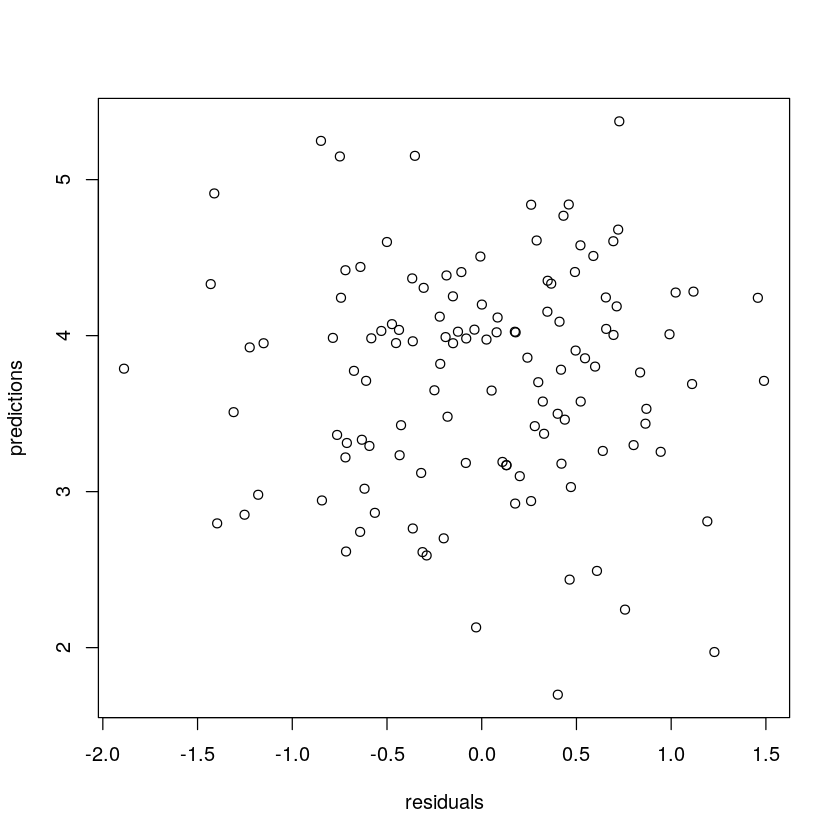

In [44]:
complete_case_female_model$predictions = predict(complete_case_female_model,
    newdata=complete_case_female_data)
plot_residuals(complete_case_female_model)

#### Multiple Imputation

In [45]:
mi_female_data = mice(raw_female_data, m=num_imputed_datasets, maxit=20, seed=664,
    defaultMethod=c('norm.nob','logreg','lda','polr'))


 iter imp variable
  1   1  depress  phydisab  psydisab  severity
  1   2  depress  phydisab  psydisab  severity
  1   3  depress  phydisab  psydisab  severity
  1   4  depress  phydisab  psydisab  severity
  1   5  depress  phydisab  psydisab  severity
  1   6  depress  phydisab  psydisab  severity
  1   7  depress  phydisab  psydisab  severity
  1   8  depress  phydisab  psydisab  severity
  1   9  depress  phydisab  psydisab  severity
  1   10  depress  phydisab  psydisab  severity
  1   11  depress  phydisab  psydisab  severity
  1   12  depress  phydisab  psydisab  severity
  1   13  depress  phydisab  psydisab  severity
  1   14  depress  phydisab  psydisab  severity
  1   15  depress  phydisab  psydisab  severity
  1   16  depress  phydisab  psydisab  severity
  1   17  depress  phydisab  psydisab  severity
  1   18  depress  phydisab  psydisab  severity
  1   19  depress  phydisab  psydisab  severity
  1   20  depress  phydisab  psydisab  severity
  2   1  depress  phydisab  p

In [46]:
summarize_pooled_results(mi_female_data, precision=5)

,mean,Vw,Vb,SE,Vt,FMI,MR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
depress,4.00106,0.00413,0.00054,0.06858,0.00470,0.00830,0.21613
phydisab,9.97183,0.01692,0.00041,0.13173,0.01735,0.00327,0.02903
psydisab,10.91831,0.01386,0.00021,0.11866,0.01408,0.00186,0.01290
age,44.13889,0.46566,0.00000,0.68239,0.46566,0.00000,0.00000


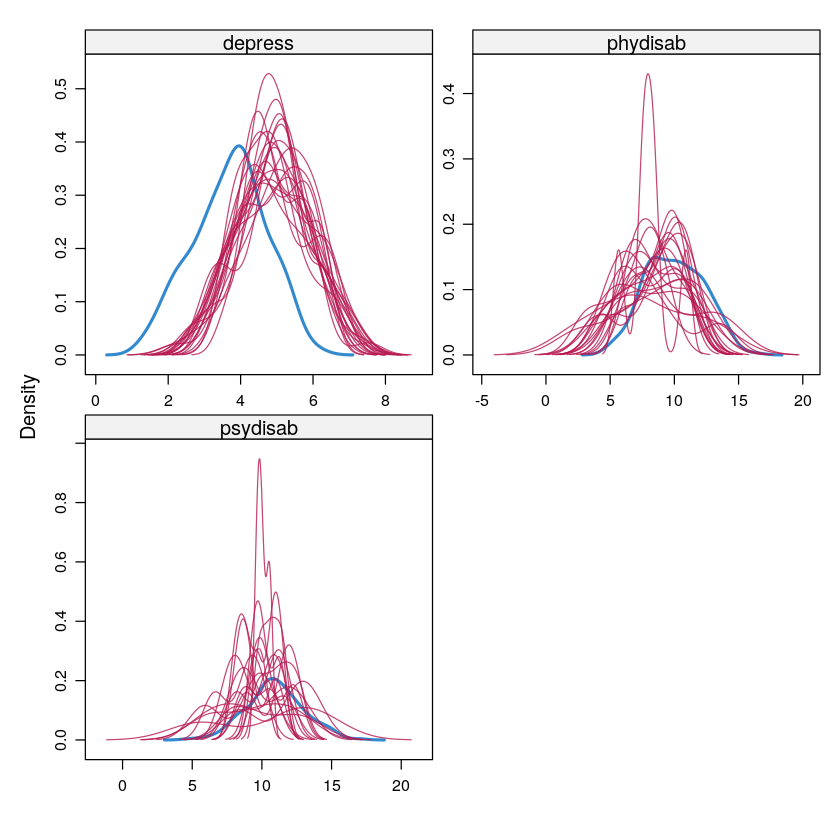

In [47]:
densityplot(mi_female_data)

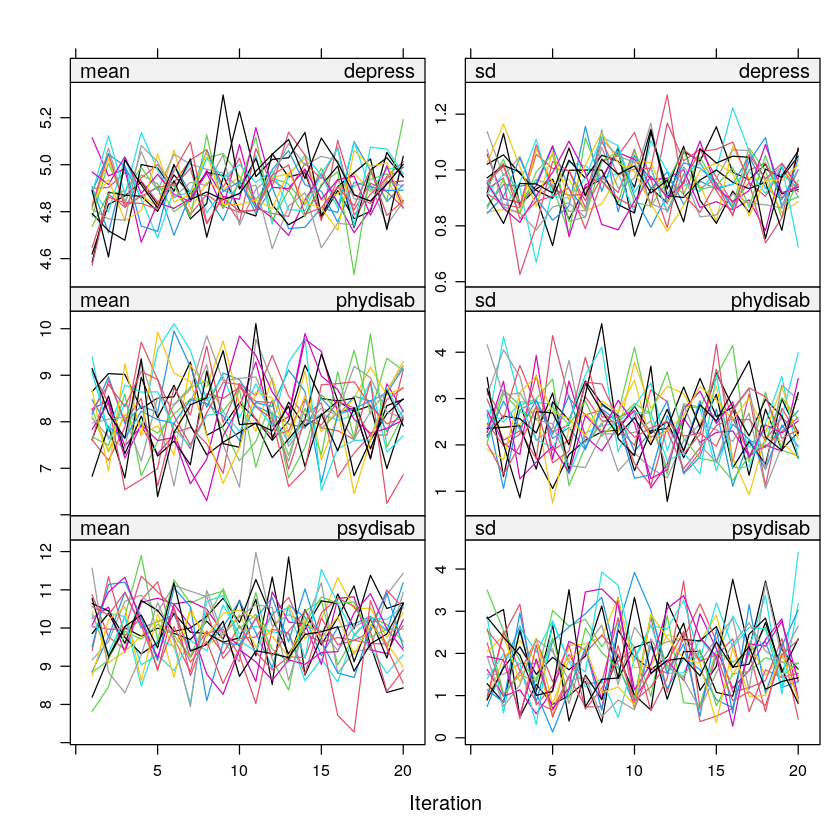

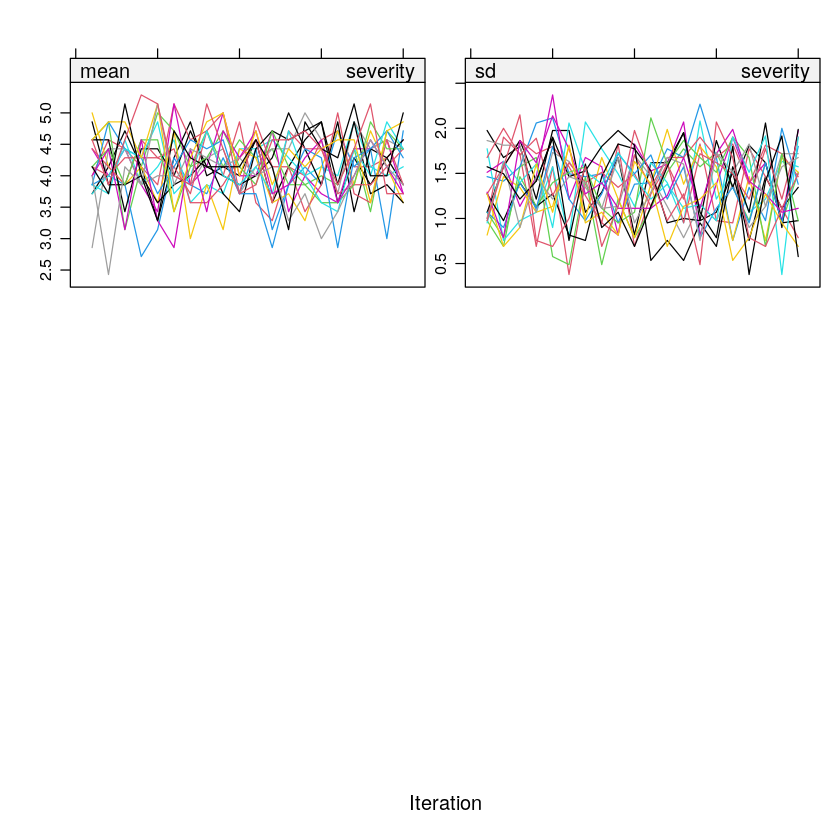

In [48]:
plot(mi_female_data)

In [49]:
mi_female_model = build_linear_model(mi_female_data)
women_only_model_fits[['multiple imputation']] =
    summary(pool(mi_female_model))
women_only_model_fits[['multiple imputation']]

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.342249166,0.408305696,0.838217956,79.93465,4.044078e-01
phydisab,0.119479245,0.035731394,3.343817083,74.27308,1.297277e-03
psydisab,0.317735276,0.034151103,9.303807035,112.45869,1.332268e-15
severity.L,0.122072555,0.192843689,0.633012964,90.96191,5.283134e-01
severity.Q,0.320676583,0.164491479,1.949502708,111.83883,5.373906e-02
severity.C,-0.001115151,0.178568144,-0.006244963,76.55672,9.950335e-01
severity^4,-0.179363881,0.159162358,-1.126923998,111.48032,2.621945e-01
severity^5,0.093260063,0.142330661,0.655235227,110.29991,5.136806e-01
age,-0.022360544,0.005311047,-4.210194880,82.03194,6.495451e-05


In [50]:
reduced_mi_female_model = build_reduced_linear_model(mi_female_data)
summary(pool(reduced_mi_female_model))

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.56829815,0.331666884,13.7737543,121.6297,0.0000000000
severity.L,0.89043755,0.257319884,3.4604304,126.2257,0.0007363221
severity.Q,0.41353499,0.238849880,1.7313594,131.5807,0.0857315574
severity.C,0.15075904,0.240231398,0.6275576,132.6581,0.5313725191
severity^4,-0.36473878,0.232259129,-1.5703959,132.0679,0.1187158358
severity^5,0.26151550,0.202955396,1.2885368,147.3530,0.1995786310
age,-0.01352068,0.007204719,-1.8766419,121.8566,0.0629589626


In [51]:
women_only_lr_tests[['multiple imputation']] =
    summary(D3(mi_female_model,reduced_mi_female_model))
women_only_lr_tests[['multiple imputation']]

Models:
 model                                        formula
     1 depress ~ phydisab + psydisab + severity + age
     2                       depress ~ severity + age

Comparisons:
   test statistic df1      df2 dfcom      p.value       riv
 1 ~~ 2   39.3927   2 145.6086   171 2.109424e-14 0.9102107

Number of imputations:  20   Method D3

In [52]:
pool.r.squared(mi_female_model,adjusted=TRUE)

,est,lo 95,hi 95,fmi
adj R^2,0.6204457,0.5069345,0.7144981,0.2898239


In [53]:
tidy(pool(mi_female_model),conf.int=TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,b,df,dfcom,fmi,lambda,m,riv,ubar
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
(Intercept),0.342249166,0.408305696,0.838217956,4.044078e-01,-0.470315262,1.15481359,4.510225e-02,79.93465,171,0.3013293,0.2840643,20,0.3967734,1.193562e-01
phydisab,0.119479245,0.035731394,3.343817083,1.297277e-03,0.048287238,0.19067125,3.723820e-04,74.27308,171,0.3242072,0.3062514,20,0.4414444,8.857314e-04
psydisab,0.317735276,0.034151103,9.303807035,1.332268e-15,0.250072256,0.38539830,1.988259e-04,112.45869,171,0.1932214,0.1789999,20,0.2180266,9.575307e-04
severity.L,0.122072555,0.192843689,0.633012964,5.283134e-01,-0.260989904,0.50513501,8.676091e-03,90.96191,171,0.2610352,0.2449641,20,0.3244404,2.807879e-02
severity.Q,0.320676583,0.164491479,1.949502708,5.373906e-02,-0.005247325,0.64660049,4.658444e-03,111.83883,171,0.1950444,0.1807771,20,0.2206690,2.216608e-02
severity.C,-0.001115151,0.178568144,-0.006244963,9.950335e-01,-0.356722613,0.35449231,9.022393e-03,76.55672,171,0.3147707,0.2971003,20,0.4226781,2.241307e-02
severity^4,-0.179363881,0.159162358,-1.126923998,2.621945e-01,-0.494739746,0.13601198,4.386346e-03,111.48032,171,0.1961014,0.1818074,20,0.2222061,2.072699e-02
severity^5,0.093260063,0.142330661,0.655235227,5.136806e-01,-0.188797371,0.37531750,3.573372e-03,110.29991,171,0.1995955,0.1852126,20,0.2273140,1.650598e-02
age,-0.022360544,0.005311047,-4.210194880,6.495451e-05,-0.032925847,-0.01179524,7.421064e-06,82.03194,171,0.2932686,0.2762455,20,0.3816839,2.041511e-05


[1] "Mean residual: 0.000000"
[1] "Mean prediction: 4.001060"


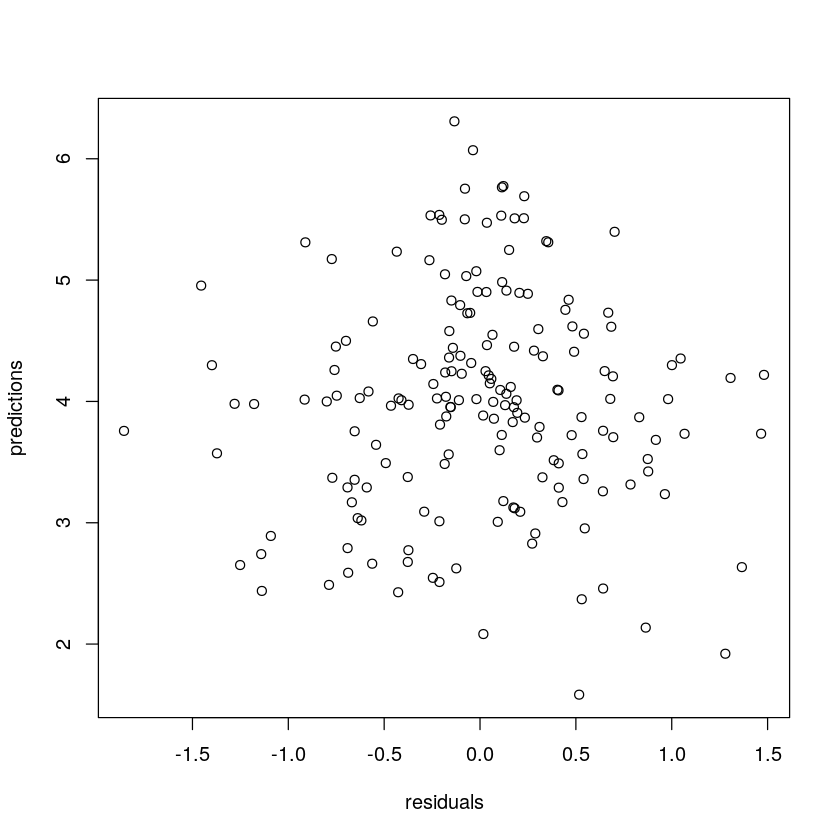

In [54]:
plot_residuals(mi_female_model, multiple_datasets=TRUE)

#### Maximum Likelihood Estimation

In [55]:
em_results = em(raw_female_data,
    cols=c('depress','phydisab','psydisab','severity','age'))
em_results

1.0000000,0.5144847,0.72756005,0.27905289,-0.17027869
0.5144847,1.0000000,0.55766238,0.33511562,0.21882864
0.7275600,0.5576624,1.00000000,0.26557066,0.04810189
0.2790529,0.3351156,0.26557066,1.00000000,-0.02467314
-0.1702787,0.2188286,0.04810189,-0.02467314,1.00000000


In [56]:
em_female_model_coeffs = coeff_em(raw_female_data, em_results, 1,
    predictor_cols=c(2,3,4,5))
em_female_model_coeffs

,coeffs,std_err,corr
,<dbl>,<dbl>,<dbl>
(Intercept),0.27436337,0.11883774,1.0000000
phydisab,0.10461925,0.04930481,0.5144847
psydisab,0.32430365,0.07215827,0.7275600
severity,0.02935823,0.03666557,0.2790529
age,-0.02258802,0.01031120,-0.1702787


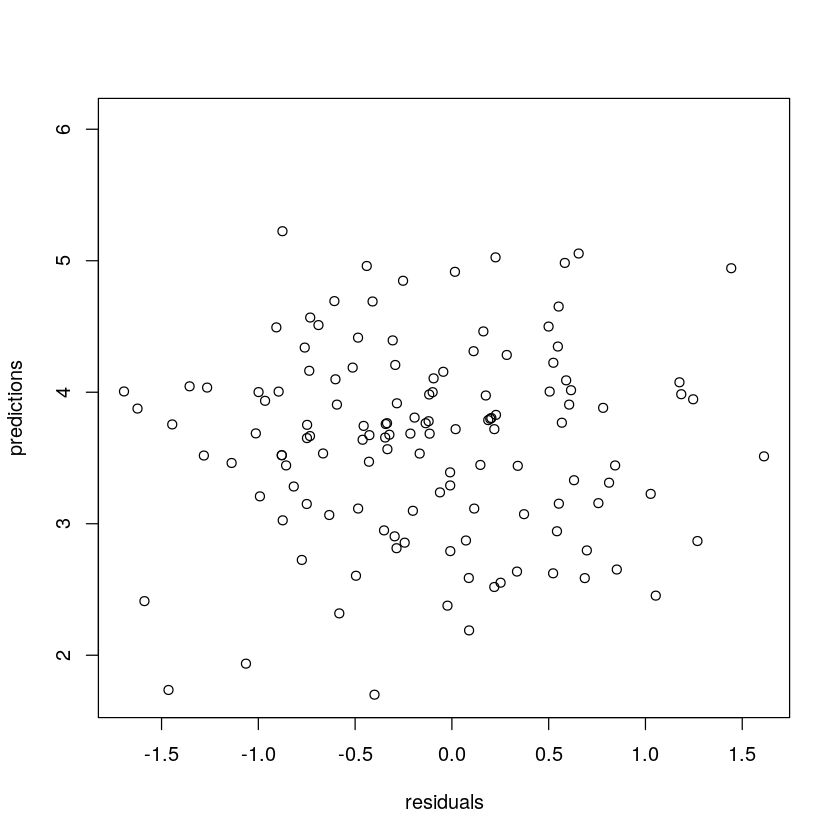

In [57]:
em_female_model_predictions = em_female_model_coeffs$coeffs[1] +
    em_female_model_coeffs$coeffs[2]*raw_female_data$phydisab +
    em_female_model_coeffs$coeffs[3]*raw_female_data$psydisab +
    em_female_model_coeffs$coeffs[5]*raw_female_data$age
em_female_model_residuals = em_female_model_predictions - raw_female_data$depress

plot(em_female_model_residuals,em_female_model_predictions,
     xlab='residuals',ylab='predictions')

## Men Only

In [58]:
pdf(file.path(FIG_DIR,'correlations_men_only.pdf'))
pairs.panels(raw_male_data,ellipses=FALSE)
dev.off()

Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphic

png 
  2

In [59]:
men_only_model_fits = list(stratum='men only')
men_only_lr_tests = list(stratum='men only')

### Listwise Deletion

In [60]:
complete_case_male_data = listwise_deletion(raw_male_data)
summary(complete_case_male_data)

    depress         phydisab         psydisab      severity      age       
 Min.   :1.800   Min.   : 5.200   Min.   : 5.900   1: 9     Min.   : 7.00  
 1st Qu.:3.400   1st Qu.: 8.075   1st Qu.: 9.275   2:14     1st Qu.:35.00  
 Median :3.900   Median : 9.600   Median :10.750   3:15     Median :43.00  
 Mean   :3.914   Mean   : 9.623   Mean   :10.475   4:24     Mean   :43.10  
 3rd Qu.:4.400   3rd Qu.:11.225   3rd Qu.:11.600   5:25     3rd Qu.:51.25  
 Max.   :6.900   Max.   :13.600   Max.   :14.900   6: 9     Max.   :74.00  

In [61]:
complete_case_male_model = build_linear_model(complete_case_male_data)
men_only_model_fits[['complete case']] = summary(complete_case_male_model)
men_only_model_fits[['complete case']]


Call:
lm(formula = depress ~ phydisab + psydisab + severity + age)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.40771 -0.64899 -0.06651  0.57007  2.15780 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.231055   0.714677   5.920 6.24e-08 ***
phydisab    -0.066877   0.055108  -1.214  0.22820    
psydisab     0.091781   0.062871   1.460  0.14794    
severity.L   0.829032   0.311166   2.664  0.00919 ** 
severity.Q   0.218944   0.294539   0.743  0.45928    
severity.C  -0.409440   0.257138  -1.592  0.11494    
severity^4  -0.163895   0.239523  -0.684  0.49563    
severity^5   0.240628   0.226842   1.061  0.29173    
age         -0.016259   0.008146  -1.996  0.04908 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.966 on 87 degrees of freedom
Multiple R-squared:  0.222,	Adjusted R-squared:  0.1504 
F-statistic: 3.103 on 8 and 87 DF,  p-value: 0.003965


In [62]:
reduced_complete_case_male_model = build_reduced_linear_model(complete_case_male_data)
summary(reduced_complete_case_male_model)


Call:
lm(formula = depress ~ severity + age)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.31040 -0.71515 -0.00069  0.53514  2.38866 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.563550   0.349995  13.039  < 2e-16 ***
severity.L   0.837408   0.300219   2.789  0.00646 ** 
severity.Q   0.262225   0.288574   0.909  0.36597    
severity.C  -0.416371   0.258429  -1.611  0.11068    
severity^4  -0.178575   0.237302  -0.753  0.45372    
severity^5   0.263058   0.227585   1.156  0.25083    
age         -0.016529   0.007769  -2.127  0.03615 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.971 on 89 degrees of freedom
Multiple R-squared:  0.1958,	Adjusted R-squared:  0.1416 
F-statistic: 3.611 on 6 and 89 DF,  p-value: 0.002984


In [63]:
men_only_lr_tests[['complete case']] =
    lrtest(complete_case_male_model, reduced_complete_case_male_model)
men_only_lr_tests[['complete case']]

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10,-128.1741,NA,NA,NA
2,8,-129.7634,-2,3.178748,0.2040533


In [64]:
# Can only compute for numeric columns
cor(complete_case_male_data[c(1,2,3,5)],method='pearson')

,depress,phydisab,psydisab,age
depress,1.00000000,-0.05777609,0.1550124,-0.1964560
phydisab,-0.05777609,1.00000000,0.3454519,0.2821098
psydisab,0.15501243,0.34545192,1.0000000,0.2141386
age,-0.19645604,0.28210984,0.2141386,1.0000000


[1] "Mean residual: 0.000000"
[1] "Mean prediction: 3.913542"


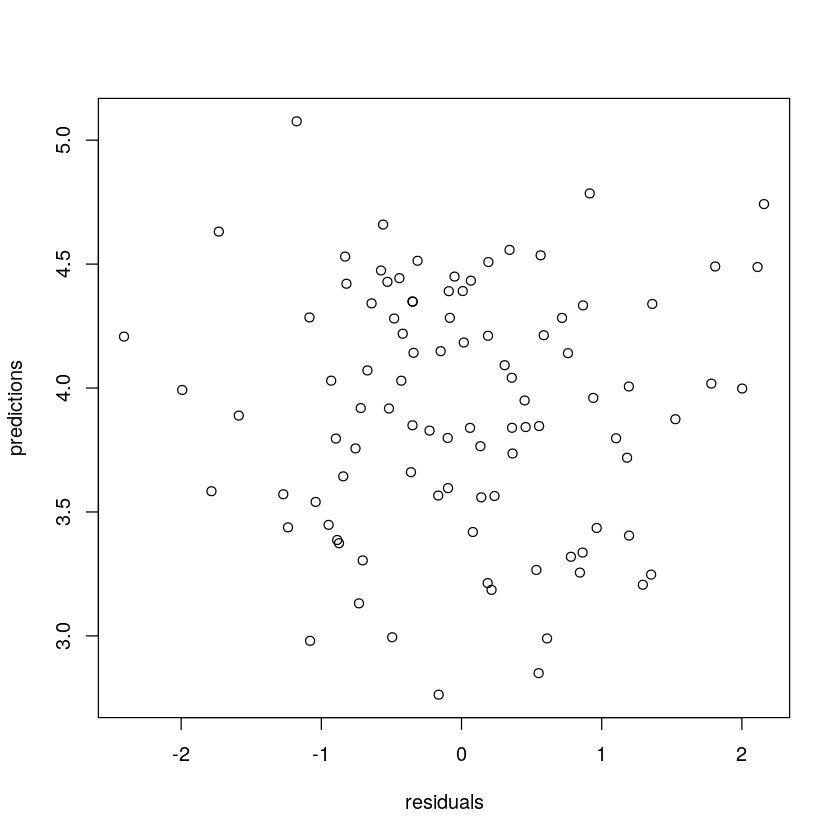

In [65]:
complete_case_male_model$predictions = predict(complete_case_male_model,
    newdata=complete_case_male_data)
plot_residuals(complete_case_male_model)

#### Multiple Imputation

In [66]:
mi_male_data = mice(raw_male_data, m=num_imputed_datasets, maxit=20, seed=664,
    defaultMethod=c('norm.nob','logreg','lda','polr'))


 iter imp variable
  1   1  depress  phydisab  psydisab  severity
  1   2  depress  phydisab  psydisab  severity
  1   3  depress  phydisab  psydisab  severity
  1   4  depress  phydisab  psydisab  severity
  1   5  depress  phydisab  psydisab  severity
  1   6  depress  phydisab  psydisab  severity
  1   7  depress  phydisab  psydisab  severity
  1   8  depress  phydisab  psydisab  severity
  1   9  depress  phydisab  psydisab  severity
  1   10  depress  phydisab  psydisab  severity
  1   11  depress  phydisab  psydisab  severity
  1   12  depress  phydisab  psydisab  severity
  1   13  depress  phydisab  psydisab  severity
  1   14  depress  phydisab  psydisab  severity
  1   15  depress  phydisab  psydisab  severity
  1   16  depress  phydisab  psydisab  severity
  1   17  depress  phydisab  psydisab  severity
  1   18  depress  phydisab  psydisab  severity
  1   19  depress  phydisab  psydisab  severity
  1   20  depress  phydisab  psydisab  severity
  2   1  depress  phydisab  p

In [67]:
summarize_pooled_results(mi_male_data, precision=5)

,mean,Vw,Vb,SE,Vt,FMI,MR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
depress,3.96616,0.00385,0.00089,0.06911,0.00478,0.01347,0.21613
phydisab,9.98793,0.01543,0.00069,0.12709,0.01615,0.00568,0.02903
psydisab,10.96462,0.01398,0.00022,0.11919,0.01421,0.00192,0.01290
age,43.80769,0.52254,0.00000,0.72287,0.52254,0.00000,0.00000


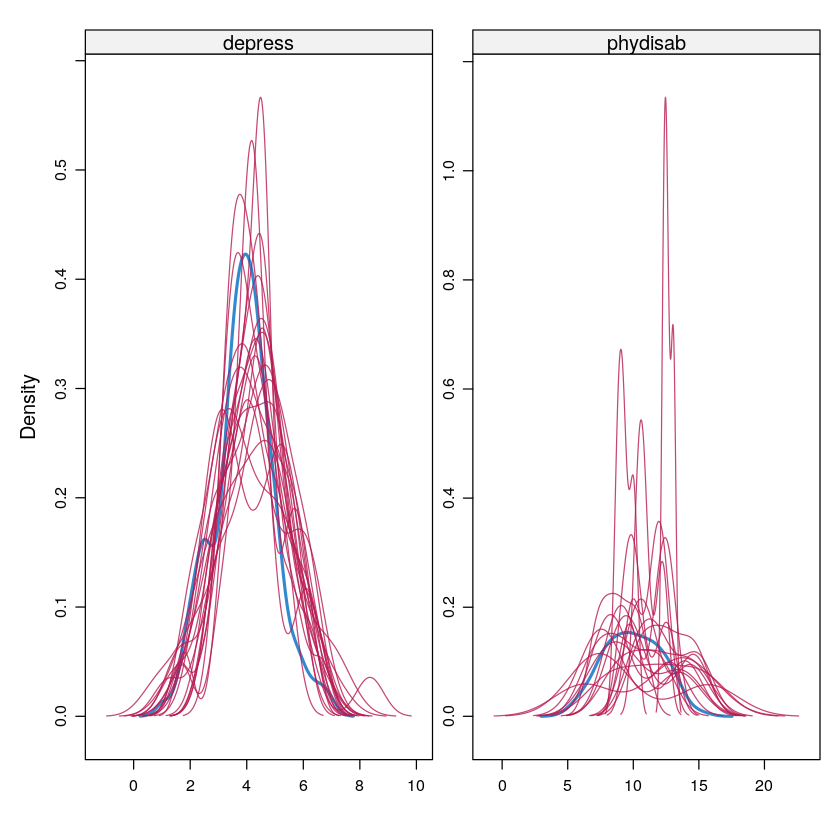

In [68]:
densityplot(mi_male_data)

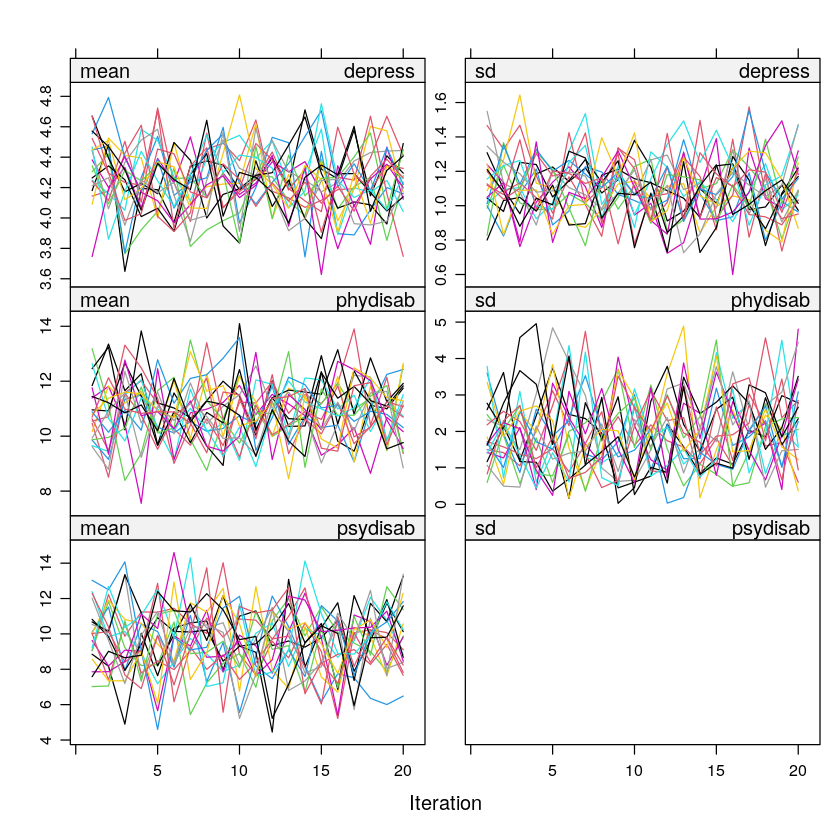

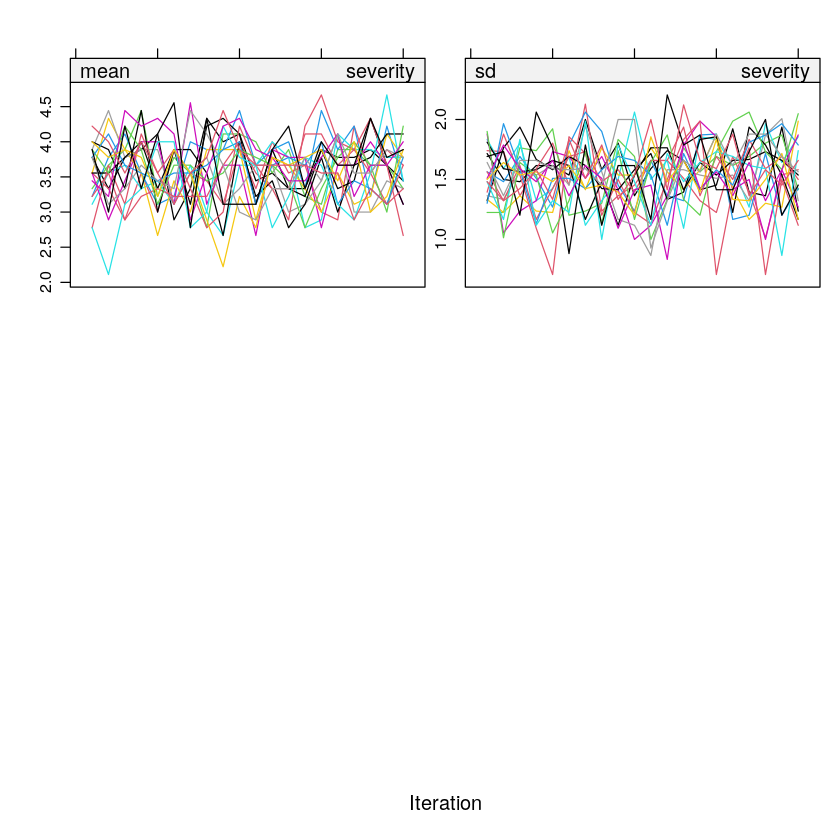

In [69]:
plot(mi_male_data)

In [70]:
mi_male_model = build_linear_model(mi_male_data)
men_only_model_fits[['multiple imputation']] = summary(pool(mi_male_model))
men_only_model_fits[['multiple imputation']]

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.05124193,0.631952768,6.4106720,82.68242,8.455983e-09
phydisab,-0.05057771,0.051376032,-0.9844612,99.50544,3.272765e-01
psydisab,0.10294624,0.054790943,1.8788916,78.04231,6.399304e-02
severity.L,0.85414356,0.333559967,2.5606897,61.67778,1.290868e-02
severity.Q,0.22357408,0.284053142,0.7870854,80.93509,4.335307e-01
severity.C,-0.41873724,0.252727360,-1.6568734,79.47963,1.014878e-01
severity^4,-0.07636040,0.242280796,-0.3151732,69.93773,7.535687e-01
severity^5,0.27962821,0.236113999,1.1842932,69.63833,2.403234e-01
age,-0.01818822,0.007643005,-2.3797218,97.43799,1.927296e-02


In [71]:
reduced_mi_male_model = build_reduced_linear_model(mi_male_data)
summary(pool(reduced_mi_male_model))

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.67434202,0.335877988,13.9167858,99.93129,0.000000000
severity.L,0.91383528,0.313373754,2.9161194,62.67278,0.004912038
severity.Q,0.21877690,0.284511165,0.7689572,83.68952,0.444083442
severity.C,-0.44191704,0.256288145,-1.7242976,78.56604,0.088586748
severity^4,-0.13523360,0.246732777,-0.5480974,64.18387,0.585526307
severity^5,0.32587642,0.238197665,1.3680924,69.12282,0.175714155
age,-0.01843396,0.007442986,-2.4766887,96.50820,0.015000880


In [72]:
men_only_lr_tests[['multiple imputation']] =
    summary(D3(mi_male_model,reduced_mi_male_model))
men_only_lr_tests[['multiple imputation']]

Models:
 model                                        formula
     1 depress ~ phydisab + psydisab + severity + age
     2                       depress ~ severity + age

Comparisons:
   test statistic df1     df2 dfcom   p.value       riv
 1 ~~ 2  1.943597   2 973.525   121 0.1437432 0.2182884

Number of imputations:  20   Method D3

In [73]:
pool.r.squared(mi_male_model,adjusted=TRUE)

,est,lo 95,hi 95,fmi
adj R^2,0.1897565,0.07022155,0.3361434,0.2107367


In [74]:
tidy(pool(mi_male_model),conf.int=TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,b,df,dfcom,fmi,lambda,m,riv,ubar
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
(Intercept),4.05124193,0.631952768,6.4106720,8.455983e-09,2.794241889,5.308241968,7.020384e-02,82.68242,121,0.2036120,0.1845784,20,0.2263595,3.256503e-01
phydisab,-0.05057771,0.051376032,-0.9844612,3.272765e-01,-0.152512502,0.051357076,2.736443e-04,99.50544,121,0.1262438,0.1088566,20,0.1221538,2.352170e-03
psydisab,0.10294624,0.054790943,1.8788916,6.399304e-02,-0.006133216,0.212025698,5.890394e-04,78.04231,121,0.2256173,0.2060232,20,0.2594826,2.383556e-03
severity.L,0.85414356,0.333559967,2.5606897,1.290868e-02,0.187297391,1.520989735,3.063078e-02,61.67778,121,0.3110515,0.2890676,20,0.4066036,7.909994e-02
severity.Q,0.22357408,0.284053142,0.7870854,4.335307e-01,-0.341609445,0.788757603,1.479906e-02,80.93509,121,0.2118248,0.1925857,20,0.2385216,6.514718e-02
severity.C,-0.41873724,0.252727360,-1.6568734,1.014878e-01,-0.921731272,0.084256790,1.212430e-02,79.47963,121,0.2187310,0.1993157,20,0.2489317,5.114060e-02
severity^4,-0.07636040,0.242280796,-0.3151732,7.535687e-01,-0.559581777,0.406860973,1.371523e-02,69.93773,121,0.2660256,0.2453321,20,0.3250862,4.429899e-02
severity^5,0.27962821,0.236113999,1.1842932,2.403234e-01,-0.191329313,0.750585738,1.310616e-02,69.63833,121,0.2675804,0.2468432,20,0.3277447,4.198836e-02
age,-0.01818822,0.007643005,-2.3797218,1.927296e-02,-0.033356612,-0.003019837,6.579988e-06,97.43799,121,0.1358308,0.1182731,20,0.1341381,5.150653e-05


[1] "Mean residual: 0.000000"
[1] "Mean prediction: 3.966157"


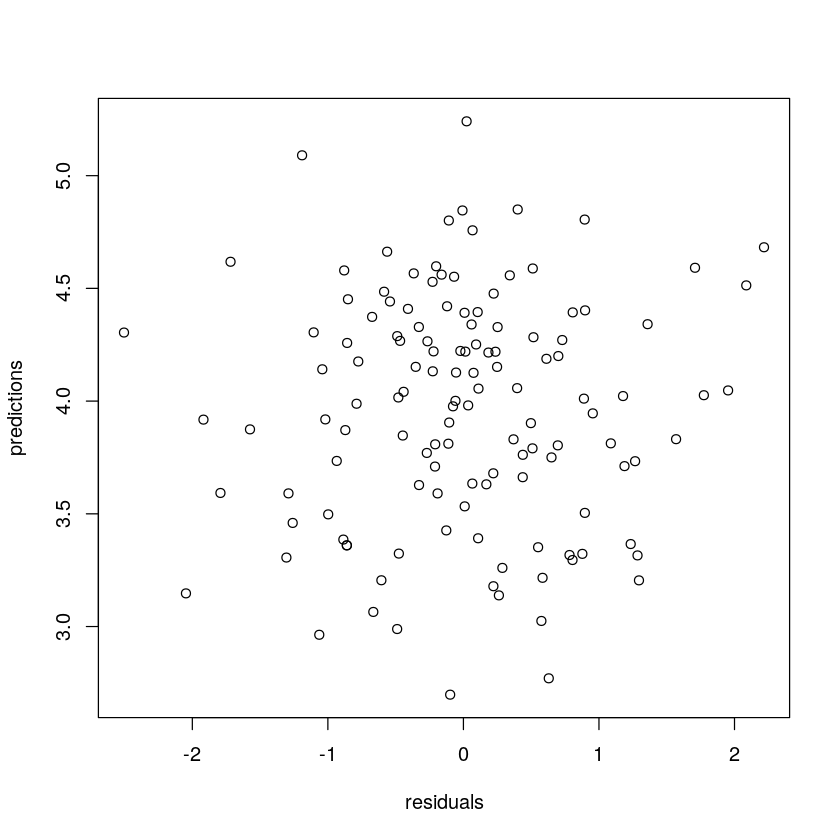

In [75]:
plot_residuals(mi_male_model, multiple_datasets=TRUE)

#### Maximum Likelihood Estimation

In [76]:
em_results = em(raw_male_data,
    cols=c('depress','phydisab','psydisab','severity','age'))
em_results

1.00000000,0.03329481,0.2328935,0.32707600,-0.21969389
0.03329481,1.00000000,0.4823637,0.34926816,0.29040627
0.23289346,0.48236372,1.0000000,0.29532924,0.13654800
0.32707600,0.34926816,0.2953292,1.00000000,0.05687259
-0.21969389,0.29040627,0.1365480,0.05687259,1.00000000


In [77]:
em_male_model_coeffs = coeff_em(raw_male_data, em_results, 1,
    predictor_cols=c(2,3,4,5))
em_male_model_coeffs

,coeffs,std_err,corr
,<dbl>,<dbl>,<dbl>
(Intercept),3.24292897,0.09828844,1.00000000
phydisab,-0.05904998,0.01383876,0.03329481
psydisab,0.11913776,0.03609557,0.23289346
severity,0.23060019,0.04887444,0.32707600
age,-0.01988243,0.01291839,-0.21969389


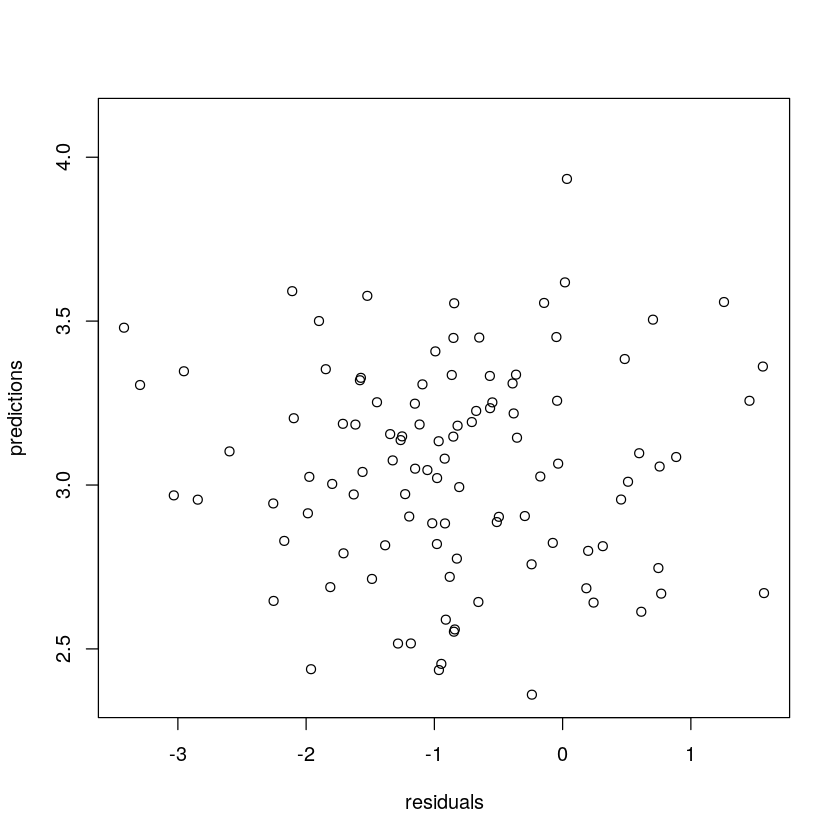

In [78]:
em_male_model_predictions = em_male_model_coeffs$coeffs[1] +
    em_male_model_coeffs$coeffs[2]*raw_male_data$phydisab +
    em_male_model_coeffs$coeffs[3]*raw_male_data$psydisab +
    em_male_model_coeffs$coeffs[5]*raw_male_data$age
em_male_model_residuals = em_male_model_predictions - raw_male_data$depress

plot(em_male_model_residuals,em_male_model_predictions,
     xlab='residuals',ylab='predictions')

## Summary

In [79]:
plot_test_results = function(test_results, outfilename, alpha=0.05) {
    
}

In [80]:
full_data_lr_tests

$stratum
[1] "full data"

$`complete case`
Likelihood ratio test

Model 1: depress ~ phydisab + psydisab + severity + age
Model 2: depress ~ severity + age
  #Df  LogLik Df  Chisq Pr(>Chisq)    
1  10 -272.91                         
2   8 -296.13 -2 46.433  8.266e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$`multiple imputation`

Models:
 model                                        formula
     1 depress ~ phydisab + psydisab + severity + age
     2                       depress ~ severity + age

Comparisons:
   test statistic df1      df2 dfcom      p.value       riv
 1 ~~ 2  35.84074   2 483.8504   301 3.108624e-15 0.3436528

Number of imputations:  20   Method D3

In [100]:
tabulate_lr_tests = function(lr_tests) {
    df = data.frame(p.value=c(
                lr_tests[['complete case']][2,5],
                lr_tests[['multiple imputation']]$comparisons[1,6]),
            techniques=names(full_data_lr_tests)[-1])
    df$stratum = lr_tests$stratum
    
    return(df)
}

plot_lr_test_results = function(lr_test_list, out_filename, alpha=0.05) {
    # Consolidate all of the data into a single df for easier plotting
    lr_test_dfs = lapply(lr_test_list, tabulate_lr_tests)
    lr_tests = Reduce(rbind,lr_test_dfs)

    # Use a log scale so the smaller p-values are visibile
    lr_test_plot = ggplot(lr_tests, aes(x=stratum, y=p.value, fill=techniques)) +
            geom_bar(stat='identity', position='dodge') +
            labs(title='Log-Likelihood Ratio Test Results') +
            geom_hline(yintercept=0.05,linetype='dashed') +
            scale_y_log10()
    
    pdf(file.path(FIG_DIR, out_filename))
    print(lr_test_plot)
    dev.off()
}

In [101]:
all_lr_tests = list(full_data_lr_tests, women_only_lr_tests,
    men_only_lr_tests)
plot_lr_test_results(all_lr_tests, 'lr_test_p_values.pdf')

png 
  2

In [108]:
plot_model_fits = function(model_fits, out_filename, alpha=0.05) {
    cc_coeffs = data.frame(model_fits[['complete case']]$coefficients)
    mi_coeffs = model_fits[['multiple imputation']]
    
    # Clean up dataframes so that they match
    names(cc_coeffs) = c('estimate', 'std.error', 'statistic', 'p.value')
    cc_coeffs$term = mi_coeffs$term
    rownames(cc_coeffs) = NULL

    mi_coeffs = mi_coeffs[,-5]

    # Label both sets of coefficients so they can be grouped later
    cc_coeffs$technique = 'complete case analysis'
    mi_coeffs$technique = 'multiple imputation'

    # The y-intercept is fairly large compared ot the other values and
    # not important to assessing the role of differnet variables, so let's
    # ignore it in the plot
    coeffs = rbind(mi_coeffs, cc_coeffs)
    coeffs = coeffs[coeffs$term != '(Intercept)',]
    
    # 'variable' is more consistent with the temrinology we use in the
    # paper than 'term'
    names(coeffs)[1] = 'variable'

    est_plot = ggplot(coeffs, aes(x=technique, y=estimate, fill=variable)) +
        geom_bar(stat='identity', position='dodge') +
        labs(title='Linear Model Coefficient Estimates')
    pdf(file.path(FIG_DIR,sprintf(out_filename,'coeff_ests')))
    print(est_plot)
    dev.off()
    
    p_val_plot = ggplot(coeffs, aes(x=technique, y=p.value, fill=variable)) +
        geom_bar(stat='identity', position='dodge') +
        labs(title='Linear Model Coefficient p-values') +
        geom_hline(yintercept=alpha,linetype='dashed')
    pdf(file.path(FIG_DIR,sprintf(out_filename,'coeff_p_values')))
    print(p_val_plot)
    dev.off()
}

In [109]:
plot_model_fits(full_data_model_fits,'%s_full_data.pdf')
plot_model_fits(women_only_model_fits,'%s_women_only.pdf')
plot_model_fits(men_only_model_fits,'%s_men_only.pdf')

png 
  2

png 
  2

png 
  2